# LimberJack Target Practice

## Model

In [38]:
using LinearAlgebra
using Turing
using AdvancedHMC
using LimberJack
using DataFrames
using CSV
using YAML
using NPZ
using PythonCall
sacc = pyimport("sacc");

using Revise
using MCHMC

In [2]:
sacc_path = "/home/jaimerz/PhD/LimberJack.jl/data/FD/cls_FD_covG.fits"
yaml_path = "/home/jaimerz/PhD/LimberJack.jl/data/DESY1/gcgc_gcwl_wlwl.yml"
sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)
meta, files = make_data(sacc_file, yaml_file)

data_vector = meta.data
cov_tot = meta.cov
errs = sqrt.(diag(cov_tot))
fake_data = data_vector ./ errs
fake_cov = Hermitian(cov_tot ./ (errs * errs'));

DESgc__0 DESgc__0 5
DESgc__1 DESgc__1 8
DESgc__2 DESgc__2 10
DESgc__3 DESgc__3 11
DESgc__4 DESgc__4 13
DESgc__0 DESwl__0 5
DESgc__0 DESwl__1 5
DESgc__0 DESwl__2 5
DESgc__0 DESwl__3 5
DESgc__1 DESwl__0 8
DESgc__1 DESwl__1 8
DESgc__1 DESwl__2 8
DESgc__1 DESwl__3 8
DESgc__2 DESwl__0 10
DESgc__2 DESwl__1 10
DESgc__2 DESwl__2 10
DESgc__2 DESwl__3 10
DESgc__3 DESwl__0 11
DESgc__3 DESwl__1 11
DESgc__3 DESwl__2 11
DESgc__3 DESwl__3 11
DESgc__4 DESwl__0 13
DESgc__4 DESwl__1 13
DESgc__4 DESwl__2 13
DESgc__4 DESwl__3 13
DESwl__0 DESwl__0 24
DESwl__0 DESwl__1 24
DESwl__0 DESwl__2 24
DESwl__0 DESwl__3 24
DESwl__1 DESwl__1 24
DESwl__1 DESwl__2 24
DESwl__1 DESwl__3 24
DESwl__2 DESwl__2 24
DESwl__2 DESwl__3 24
DESwl__3 DESwl__3 24


In [3]:
@model function model(data;
                      cov=fake_cov,
                      meta=meta, 
                      files=files)
    #KiDS priors
    Ωm ~ Uniform(0.2, 0.6)
    Ωb ~ Uniform(0.028, 0.065)
    h ~ TruncatedNormal(72, 5, 0.64, 0.82)
    s8 ~ Uniform(0.4, 1.2)
    ns ~ Uniform(0.84, 1.1)

    DESgc__0_b ~ Uniform(0.8, 3.0)
    DESgc__1_b ~ Uniform(0.8, 3.0)
    DESgc__2_b ~ Uniform(0.8, 3.0)
    DESgc__3_b ~ Uniform(0.8, 3.0)
    DESgc__4_b ~ Uniform(0.8, 3.0)
    DESgc__0_dz ~ TruncatedNormal(0.0, 0.007, -0.2, 0.2)
    DESgc__1_dz ~ TruncatedNormal(0.0, 0.007, -0.2, 0.2)
    DESgc__2_dz ~ TruncatedNormal(0.0, 0.006, -0.2, 0.2)
    DESgc__3_dz ~ TruncatedNormal(0.0, 0.01, -0.2, 0.2)
    DESgc__4_dz ~ TruncatedNormal(0.0, 0.01, -0.2, 0.2)
    DESwl__0_dz ~ TruncatedNormal(-0.001, 0.016, -0.2, 0.2)
    DESwl__1_dz ~ TruncatedNormal(-0.019, 0.013, -0.2, 0.2)
    DESwl__2_dz ~ TruncatedNormal(0.009, 0.011, -0.2, 0.2)
    DESwl__3_dz ~ TruncatedNormal(-0.018, 0.022, -0.2, 0.2)
    DESwl__0_m ~ Normal(0.012, 0.023)
    DESwl__1_m ~ Normal(0.012, 0.023)
    DESwl__2_m ~ Normal(0.012, 0.023)
    DESwl__3_m ~ Normal(0.012, 0.023)
    A_IA ~ Uniform(-5, 5) 
    alpha_IA ~ Uniform(-5, 5)

    nuisances = Dict("DESgc__0_b" => DESgc__0_b,
                     "DESgc__1_b" => DESgc__1_b,
                     "DESgc__2_b" => DESgc__2_b,
                     "DESgc__3_b" => DESgc__3_b,
                     "DESgc__4_b" => DESgc__4_b,
                     "DESgc__0_dz" => DESgc__0_dz,
                     "DESgc__1_dz" => DESgc__1_dz,
                     "DESgc__2_dz" => DESgc__2_dz,
                     "DESgc__3_dz" => DESgc__3_dz,
                     "DESgc__4_dz" => DESgc__4_dz,
                     "DESwl__0_dz" => DESwl__0_dz,
                     "DESwl__1_dz" => DESwl__1_dz,
                     "DESwl__2_dz" => DESwl__2_dz,
                     "DESwl__3_dz" => DESwl__3_dz,
                     "DESwl__0_m" => DESwl__0_m,
                     "DESwl__1_m" => DESwl__1_m,
                     "DESwl__2_m" => DESwl__2_m,
                     "DESwl__3_m" => DESwl__3_m,
                     "A_IA" => A_IA,
                     "alpha_IA" => alpha_IA,)

    cosmology = Cosmology(Ωm, Ωb, h, ns, s8,
                          tk_mode="EisHu",
                          Pk_mode="Halofit")

    theory = Theory(cosmology, meta, files; Nuisances=nuisances)
    data ~ MvNormal(theory ./ errs, cov)
end

model (generic function with 2 methods)

In [4]:
stat_model = model(fake_data)

DynamicPPL.Model{typeof(model), (:data, :cov, :meta, :files), (:cov, :meta, :files), (), Tuple{Vector{Float64}, Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, Tuple{Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, DynamicPPL.DefaultContext}(model, (data = [3.214096950162085, 4.70756721223778, 6.415689628953242, 5.828388701788672, 8.493679322382144, 2.9304058751712, 7.998464834088993, 5.1210836387672565, 8.932453735970117, 8.407292870179436  …  1.8338144344899103, 3.6747343455612156, 2.7292480563019765, 2.265947203686935, 3.1513497907284673, 2.887098863974196, 0.7659895057386662, 2.8855449419318098, 2.3446896354956963, 1.6352516474328562], cov = [1.0 -0.289532718133784 … -4.320136350638793e-5 -4.4205040697944595e-5; -0.289532718133784 0.9999999999999998 … -9.461726942265441e-5 -9.845166181745778e-5; … ; -4.320136350638793e-5 -9.461726942265441e-5 … 0.9999999999999998 0.0033632257724296594; -4.4205040697944595e-5 -9.84516618174577

## Sampling

In [5]:
target = TuringTarget(stat_model);

In [6]:
eps=0.5
L=sqrt(20)
mchmc = Sampler(eps=eps, L=L, integrator="MN")

Sampler(MCHMC.Settings(Random.MersenneTwister(0), 0.5, 4.47213595499958, 0.0, 0.1931833275037836, 0.0005, 2000, 1000, 10, "MN"), MCHMC.Minimal_norm)

In [7]:
samples_mchmc = Sample(mchmc, target; num_steps=500)

501-element Vector{Vector{Float64}}:
 [0.535631029875147, 0.05741904383024085, 0.7613974029235351, 0.8661400362945548, 1.037907510016053, 1.9552375258994676, 1.7707517104352903, 2.733297799832136, 2.2044504642419653, 2.6408194894644854  …  -0.017682490576160337, -0.010046939461116622, 0.026071134042373295, -0.002662766344287276, 0.010634735665315228, -0.00498457519309577, -0.022339332638693667, -0.008722799465562585, 2.449668827810209, -3.221347651945675]
 [0.532614699113489, 0.057422386533436114, 0.7611390146674119, 0.7970725845769229, 1.0382833878222237, 1.9414850557403545, 1.7665741417195384, 2.718461784122056, 2.202182961445316, 2.639418362978152  …  -0.028294086645124755, -0.011062189635568875, 0.027692754661087976, -0.0016710519849225114, -0.1181339123387236, -0.03927790534027842, -0.1560448811065376, -0.12139482964578827, 1.9956054275615447, -3.1250011213653255]
 [0.530258502003623, 0.05742632546975849, 0.7612318400028821, 0.7162416156136896, 1.0387298576223487, 1.92702548210569

## Plotting

In [8]:
using AverageShiftedHistograms, Plots

In [9]:
s8s_mchmc

LoadError: UndefVarError: `s8s_mchmc` not defined

In [10]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[4] for sample in samples_mchmc];

In [11]:
Wm_mchmc_ker = ash(Wms_mchmc; m=30)
s8_mchmc_ker = ash(s8s_mchmc; m=30)

Ash
  > edges  | 0.6296 : 0.0005 : 0.87
  > kernel | biweight
  > m      | 30
  > nobs   | 501
      ┌────────────────────────────────────────┐ 
   30 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⢦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡼⠈⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠇⠀⢹⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣸⠀⠀⠈⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠇⠀⠀⠀⢇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠇⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠘⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⢇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠁⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡎⠀⠀⠀⠀⠀⠀⠀⠈⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
    0 │⠀⠀⠀⠠⠖⠒⠦⠤⠤⢄⣠⠤⠤⠖⠒⠲⠴⠒⠒⠒⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣄⣀⣀⣀⣀⠀⠀⠀⠀│ 
      └────────────────────────────────────────┘ 
      ⠀0.6⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀0.9⠀ 

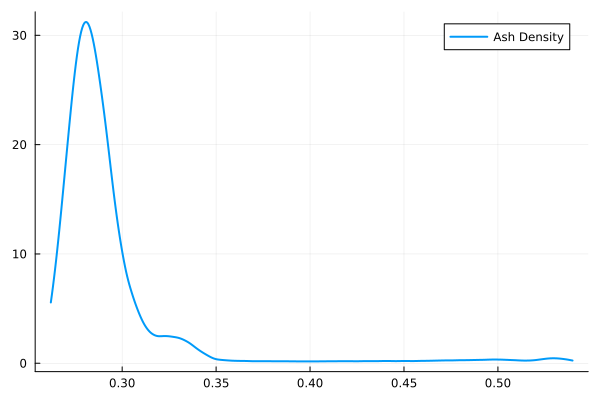

In [12]:
Plots.plot(Wm_mchmc_ker; hist=false)

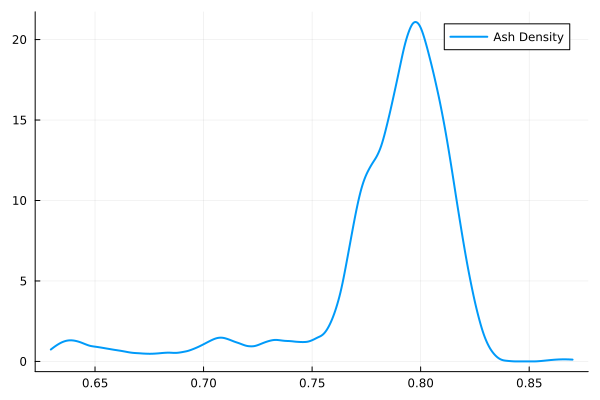

In [13]:
Plots.plot(s8_mchmc_ker; hist=false)

## NUTS

In [43]:
using Pkg
Pkg.add("DataFrames")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed DataFrames ─ v1.4.4
    Updating `~/PhD/MCHMC.jl/Project.toml`
  [a93c6f00] + DataFrames v1.4.4
    Updating `~/PhD/MCHMC.jl/Manifest.toml`
  [a8cc5b0e] + Crayons v4.1.1
  [a93c6f00] + DataFrames v1.4.4
  [59287772] + Formatting v0.4.2
  [41ab1584] + InvertedIndices v1.2.0
  [b964fa9f] + LaTeXStrings v1.3.0
  [2dfb63ee] + PooledArrays v1.4.2
  [08abe8d2] + PrettyTables v2.2.2
  [66db9d55] + SnoopPrecompile v1.0.3
  [892a3eda] + StringManipulation v0.3.0
Precompiling project...
  ✓ DataFrames
  ✓ MCHMC
  2 dependencies successfully precompiled in 32 seconds. 111 already precompiled.
  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version


In [61]:
#samples_hmc = sample(stat_model, NUTS(500, 0.65),
#                  500, progress=true; save_state=true)

summary_hmc = CSV.read("/home/jaimerz/PhD/LimberJack.jl/chains/DESY1_k1k_priors_EisHu_TAP_0.65/summary_1.csv", DataFrame)
samples_hmc = CSV.read("/home/jaimerz/PhD/LimberJack.jl/chains/DESY1_k1k_priors_EisHu_TAP_0.65/chain_1.csv", DataFrame);

In [62]:
summary_hmc.ess

25-element Vector{Float64}:
  107.13649180104869
  331.4835789816811
  207.484061400768
  111.64048654758332
  600.4013034569028
  114.39496059843647
  117.33719647252566
  114.56966849849671
  111.15547545924896
  105.06968640469209
  961.3377488207435
  700.0507524844818
  837.2166448905194
  682.3676139298411
  566.0490257440192
  837.5008331222044
  733.9973963424983
  549.1048795030388
  792.5424251430129
 1009.6818545217956
  763.2299996132994
  872.0250289709837
  763.7811879280131
  552.5319549420313
  731.942598764305

In [63]:
Wms_hmc = vec(samples_hmc[!, "Ωm"])
s8s_hmc = vec(samples_hmc[!, "s8"]);

In [64]:
Wm_hmc_ker = ash(Wms_hmc; m=30)
s8_hmc_ker = ash(s8s_hmc; m=30)
Wm_mchmc_ker = ash(Wms_mchmc; m=30)
s8_mchmc_ker = ash(s8s_mchmc; m=30);

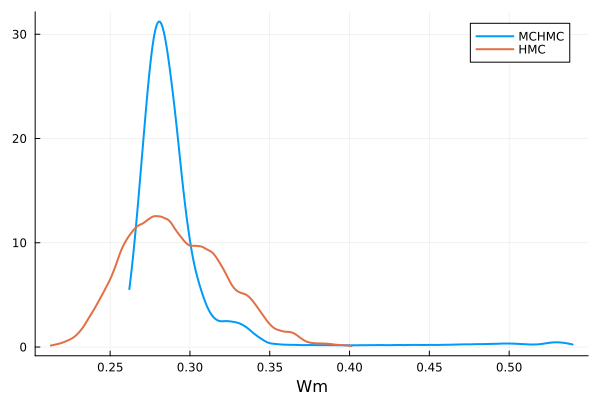

In [65]:
Plots.plot(Wm_mchmc_ker; hist=false, label="MCHMC")
Plots.plot!(Wm_hmc_ker; hist=false, label="HMC", xlabel="Wm")

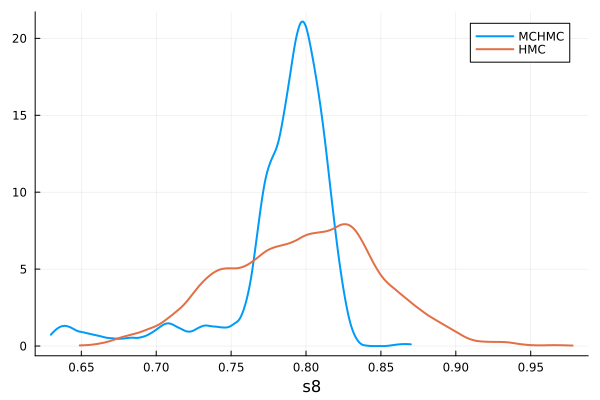

In [66]:
Plots.plot(s8_mchmc_ker; hist=false, label="MCHMC")
Plots.plot!(s8_hmc_ker; hist=false, label="HMC",  xlabel="s8")

## Self-tuning

In [25]:
mchmc = Sampler()
println(string("L = ", mchmc.settings.L, ", eps = ", mchmc.settings.eps))
# This should start self-tuning    

L = 0.0, eps = 0.0


In [26]:
mchmc.settings.tune_samples

1000

In [27]:
samples = Sample(mchmc, target; num_steps=10000, dialog=true);

Self-tuning hyperparameters


LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
      [1] [0m[1mArray[22m
    [90m    @[39m [90m./[39m[90m[4mboot.jl:477[24m[39m[90m [inlined][39m
      [2] [0m[1mArray[22m
    [90m    @[39m [90m./[39m[90m[4mboot.jl:486[24m[39m[90m [inlined][39m
      [3] [0m[1mfill[22m
    [90m    @[39m [90m./[39m[90m[4marray.jl:532[24m[39m[90m [inlined][39m
      [4] [0m[1mfill[22m
    [90m    @[39m [90m./[39m[90m[4marray.jl:531[24m[39m[90m [inlined][39m
      [5] [0m[1m(::Interpolations.FilledExtrapolation{ForwardDiff.Dual{ForwardDiff.Tag{MCHMC.var"#nlogp#19"{MCHMC.var"#inv_transform#17"{Vector{Distribution{Univariate, Continuous}}}, MCHMC.var"#11#14"{ForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{NamedTuple{(:Ωm, :Ωb, :h, :s8, :ns, :DESgc__0_b, :DESgc__1_b, :DESgc__2_b, :DESgc__3_b, :DESgc__4_b, :DESgc__0_dz, :DESgc__1_dz, :DESgc__2_dz, :DESgc__3_dz, :DESgc__4_dz, :DESwl__0_dz, :DESwl__1_dz, :DESwl__2_dz, :DESwl__3_dz, :DESwl__0_m, :DESwl__1_m, :DESwl__2_m, :DESwl__3_m, :A_IA, :alpha_IA), Tuple{DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:h, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:h, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:s8, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:s8, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:ns, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:ns, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}}, Float64}, DynamicPPL.Model{typeof(model), (:data, :cov, :meta, :files), (:cov, :meta, :files), (), Tuple{Vector{Float64}, Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, Tuple{Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.GradientConfig{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9}}}}}}, Float64}, Float64, 9}, 1, Interpolations.GriddedInterpolation{ForwardDiff.Dual{ForwardDiff.Tag{MCHMC.var"#nlogp#19"{MCHMC.var"#inv_transform#17"{Vector{Distribution{Univariate, Continuous}}}, MCHMC.var"#11#14"{ForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{NamedTuple{(:Ωm, :Ωb, :h, :s8, :ns, :DESgc__0_b, :DESgc__1_b, :DESgc__2_b, :DESgc__3_b, :DESgc__4_b, :DESgc__0_dz, :DESgc__1_dz, :DESgc__2_dz, :DESgc__3_dz, :DESgc__4_dz, :DESwl__0_dz, :DESwl__1_dz, :DESwl__2_dz, :DESwl__3_dz, :DESwl__0_m, :DESwl__1_m, :DESwl__2_m, :DESwl__3_m, :A_IA, :alpha_IA), Tuple{DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:h, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:h, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:s8, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:s8, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:ns, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:ns, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}}, Float64}, DynamicPPL.Model{typeof(model), (:data, :cov, :meta, :files), (:cov, :meta, :files), (), Tuple{Vector{Float64}, Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, Tuple{Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.GradientConfig{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9}}}}}}, Float64}, Float64, 9}, 1, Vector{ForwardDiff.Dual{ForwardDiff.Tag{MCHMC.var"#nlogp#19"{MCHMC.var"#inv_transform#17"{Vector{Distribution{Univariate, Continuous}}}, MCHMC.var"#11#14"{ForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{NamedTuple{(:Ωm, :Ωb, :h, :s8, :ns, :DESgc__0_b, :DESgc__1_b, :DESgc__2_b, :DESgc__3_b, :DESgc__4_b, :DESgc__0_dz, :DESgc__1_dz, :DESgc__2_dz, :DESgc__3_dz, :DESgc__4_dz, :DESwl__0_dz, :DESwl__1_dz, :DESwl__2_dz, :DESwl__3_dz, :DESwl__0_m, :DESwl__1_m, :DESwl__2_m, :DESwl__3_m, :A_IA, :alpha_IA), Tuple{DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:h, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:h, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:s8, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:s8, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:ns, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:ns, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}}, Float64}, DynamicPPL.Model{typeof(model), (:data, :cov, :meta, :files), (:cov, :meta, :files), (), Tuple{Vector{Float64}, Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, Tuple{Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.GradientConfig{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9}}}}}}, Float64}, Float64, 9}}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{MCHMC.var"#nlogp#19"{MCHMC.var"#inv_transform#17"{Vector{Distribution{Univariate, Continuous}}}, MCHMC.var"#11#14"{ForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{NamedTuple{(:Ωm, :Ωb, :h, :s8, :ns, :DESgc__0_b, :DESgc__1_b, :DESgc__2_b, :DESgc__3_b, :DESgc__4_b, :DESgc__0_dz, :DESgc__1_dz, :DESgc__2_dz, :DESgc__3_dz, :DESgc__4_dz, :DESwl__0_dz, :DESwl__1_dz, :DESwl__2_dz, :DESwl__3_dz, :DESwl__0_m, :DESwl__1_m, :DESwl__2_m, :DESwl__3_m, :A_IA, :alpha_IA), Tuple{DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:h, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:h, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:s8, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:s8, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:ns, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:ns, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}}, Float64}, DynamicPPL.Model{typeof(model), (:data, :cov, :meta, :files), (:cov, :meta, :files), (), Tuple{Vector{Float64}, Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, Tuple{Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.GradientConfig{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9}}}}}}, Float64}, Float64, 9}}}}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Int64})[22m[0m[1m([22m[90mx[39m::[0mVector[90m{ForwardDiff.Dual{ForwardDiff.Tag{MCHMC.var"#nlogp#19"{MCHMC.var"#inv_transform#17"{Vector{Distribution{Univariate, Continuous}}}, MCHMC.var"#11#14"{ForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{NamedTuple{(:Ωm, :Ωb, :h, :s8, :ns, :DESgc__0_b, :DESgc__1_b, :DESgc__2_b, :DESgc__3_b, :DESgc__4_b, :DESgc__0_dz, :DESgc__1_dz, :DESgc__2_dz, :DESgc__3_dz, :DESgc__4_dz, :DESwl__0_dz, :DESwl__1_dz, :DESwl__2_dz, :DESwl__3_dz, :DESwl__0_m, :DESwl__1_m, :DESwl__2_m, :DESwl__3_m, :A_IA, :alpha_IA), Tuple{DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:h, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:h, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:s8, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:s8, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:ns, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:ns, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}}, Float64}, DynamicPPL.Model{typeof(model), (:data, :cov, :meta, :files), (:cov, :meta, :files), (), Tuple{Vector{Float64}, Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, Tuple{Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.GradientConfig{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9}}}}}}, Float64}, Float64, 9}}[39m[0m[1m)[22m
    [90m    @[39m [36mInterpolations[39m [90m~/.julia/packages/Interpolations/nDwIa/src/extrapolation/[39m[90m[4mfilled.jl:49[24m[39m
      [6] [0m[1mCℓintegrand[22m[0m[1m([22m[90mcosmo[39m::[0mCosmology, [90mt1[39m::[0mInterpolations.FilledExtrapolation[90m{ForwardDiff.Dual{ForwardDiff.Tag{MCHMC.var"#nlogp#19"{MCHMC.var"#inv_transform#17"{Vector{Distribution{Univariate, Continuous}}}, MCHMC.var"#11#14"{ForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{NamedTuple{(:Ωm, :Ωb, :h, :s8, :ns, :DESgc__0_b, :DESgc__1_b, :DESgc__2_b, :DESgc__3_b, :DESgc__4_b, :DESgc__0_dz, :DESgc__1_dz, :DESgc__2_dz, :DESgc__3_dz, :DESgc__4_dz, :DESwl__0_dz, :DESwl__1_dz, :DESwl__2_dz, :DESwl__3_dz, :DESwl__0_m, :DESwl__1_m, :DESwl__2_m, :DESwl__3_m, :A_IA, :alpha_IA), Tuple{DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:h, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:h, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:s8, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:s8, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:ns, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:ns, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}}, Float64}, DynamicPPL.Model{typeof(model), (:data, :cov, :meta, :files), (:cov, :meta, :files), (), Tuple{Vector{Float64}, Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, Tuple{Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.GradientConfig{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9}}}}}}, Float64}, Float64, 9}, 1, Interpolations.GriddedInterpolation{ForwardDiff.Dual{ForwardDiff.Tag{MCHMC.var"#nlogp#19"{MCHMC.var"#inv_transform#17"{Vector{Distribution{Univariate, Continuous}}}, MCHMC.var"#11#14"{ForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{NamedTuple{(:Ωm, :Ωb, :h, :s8, :ns, :DESgc__0_b, :DESgc__1_b, :DESgc__2_b, :DESgc__3_b, :DESgc__4_b, :DESgc__0_dz, :DESgc__1_dz, :DESgc__2_dz, :DESgc__3_dz, :DESgc__4_dz, :DESwl__0_dz, :DESwl__1_dz, :DESwl__2_dz, :DESwl__3_dz, :DESwl__0_m, :DESwl__1_m, :DESwl__2_m, :DESwl__3_m, :A_IA, :alpha_IA), Tuple{DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:h, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:h, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:s8, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:s8, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:ns, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:ns, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}}, Float64}, DynamicPPL.Model{typeof(model), (:data, :cov, :meta, :files), (:cov, :meta, :files), (), Tuple{Vector{Float64}, Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, Tuple{Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.GradientConfig{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9}}}}}}, Float64}, Float64, 9}, 1, Vector{ForwardDiff.Dual{ForwardDiff.Tag{MCHMC.var"#nlogp#19"{MCHMC.var"#inv_transform#17"{Vector{Distribution{Univariate, Continuous}}}, MCHMC.var"#11#14"{ForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{NamedTuple{(:Ωm, :Ωb, :h, :s8, :ns, :DESgc__0_b, :DESgc__1_b, :DESgc__2_b, :DESgc__3_b, :DESgc__4_b, :DESgc__0_dz, :DESgc__1_dz, :DESgc__2_dz, :DESgc__3_dz, :DESgc__4_dz, :DESwl__0_dz, :DESwl__1_dz, :DESwl__2_dz, :DESwl__3_dz, :DESwl__0_m, :DESwl__1_m, :DESwl__2_m, :DESwl__3_m, :A_IA, :alpha_IA), Tuple{DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:h, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:h, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:s8, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:s8, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:ns, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:ns, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}}, Float64}, DynamicPPL.Model{typeof(model), (:data, :cov, :meta, :files), (:cov, :meta, :files), (), Tuple{Vector{Float64}, Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, Tuple{Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.GradientConfig{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9}}}}}}, Float64}, Float64, 9}}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{MCHMC.var"#nlogp#19"{MCHMC.var"#inv_transform#17"{Vector{Distribution{Univariate, Continuous}}}, MCHMC.var"#11#14"{ForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{NamedTuple{(:Ωm, :Ωb, :h, :s8, :ns, :DESgc__0_b, :DESgc__1_b, :DESgc__2_b, :DESgc__3_b, :DESgc__4_b, :DESgc__0_dz, :DESgc__1_dz, :DESgc__2_dz, :DESgc__3_dz, :DESgc__4_dz, :DESwl__0_dz, :DESwl__1_dz, :DESwl__2_dz, :DESwl__3_dz, :DESwl__0_m, :DESwl__1_m, :DESwl__2_m, :DESwl__3_m, :A_IA, :alpha_IA), Tuple{DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:h, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:h, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:s8, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:s8, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:ns, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:ns, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}}, Float64}, DynamicPPL.Model{typeof(model), (:data, :cov, :meta, :files), (:cov, :meta, :files), (), Tuple{Vector{Float64}, Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, Tuple{Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.GradientConfig{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9}}}}}}, Float64}, Float64, 9}}}}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Int64}[39m, [90mt2[39m::[0mInterpolations.FilledExtrapolation[90m{ForwardDiff.Dual{ForwardDiff.Tag{MCHMC.var"#nlogp#19"{MCHMC.var"#inv_transform#17"{Vector{Distribution{Univariate, Continuous}}}, MCHMC.var"#11#14"{ForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{NamedTuple{(:Ωm, :Ωb, :h, :s8, :ns, :DESgc__0_b, :DESgc__1_b, :DESgc__2_b, :DESgc__3_b, :DESgc__4_b, :DESgc__0_dz, :DESgc__1_dz, :DESgc__2_dz, :DESgc__3_dz, :DESgc__4_dz, :DESwl__0_dz, :DESwl__1_dz, :DESwl__2_dz, :DESwl__3_dz, :DESwl__0_m, :DESwl__1_m, :DESwl__2_m, :DESwl__3_m, :A_IA, :alpha_IA), Tuple{DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:h, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:h, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:s8, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:s8, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:ns, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:ns, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}}, Float64}, DynamicPPL.Model{typeof(model), (:data, :cov, :meta, :files), (:cov, :meta, :files), (), Tuple{Vector{Float64}, Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, Tuple{Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.GradientConfig{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9}}}}}}, Float64}, Float64, 9}, 1, Interpolations.GriddedInterpolation{ForwardDiff.Dual{ForwardDiff.Tag{MCHMC.var"#nlogp#19"{MCHMC.var"#inv_transform#17"{Vector{Distribution{Univariate, Continuous}}}, MCHMC.var"#11#14"{ForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{NamedTuple{(:Ωm, :Ωb, :h, :s8, :ns, :DESgc__0_b, :DESgc__1_b, :DESgc__2_b, :DESgc__3_b, :DESgc__4_b, :DESgc__0_dz, :DESgc__1_dz, :DESgc__2_dz, :DESgc__3_dz, :DESgc__4_dz, :DESwl__0_dz, :DESwl__1_dz, :DESwl__2_dz, :DESwl__3_dz, :DESwl__0_m, :DESwl__1_m, :DESwl__2_m, :DESwl__3_m, :A_IA, :alpha_IA), Tuple{DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:h, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:h, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:s8, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:s8, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:ns, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:ns, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}}, Float64}, DynamicPPL.Model{typeof(model), (:data, :cov, :meta, :files), (:cov, :meta, :files), (), Tuple{Vector{Float64}, Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, Tuple{Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.GradientConfig{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9}}}}}}, Float64}, Float64, 9}, 1, Vector{ForwardDiff.Dual{ForwardDiff.Tag{MCHMC.var"#nlogp#19"{MCHMC.var"#inv_transform#17"{Vector{Distribution{Univariate, Continuous}}}, MCHMC.var"#11#14"{ForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{NamedTuple{(:Ωm, :Ωb, :h, :s8, :ns, :DESgc__0_b, :DESgc__1_b, :DESgc__2_b, :DESgc__3_b, :DESgc__4_b, :DESgc__0_dz, :DESgc__1_dz, :DESgc__2_dz, :DESgc__3_dz, :DESgc__4_dz, :DESwl__0_dz, :DESwl__1_dz, :DESwl__2_dz, :DESwl__3_dz, :DESwl__0_m, :DESwl__1_m, :DESwl__2_m, :DESwl__3_m, :A_IA, :alpha_IA), Tuple{DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:h, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:h, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:s8, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:s8, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:ns, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:ns, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}}, Float64}, DynamicPPL.Model{typeof(model), (:data, :cov, :meta, :files), (:cov, :meta, :files), (), Tuple{Vector{Float64}, Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, Tuple{Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.GradientConfig{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9}}}}}}, Float64}, Float64, 9}}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{MCHMC.var"#nlogp#19"{MCHMC.var"#inv_transform#17"{Vector{Distribution{Univariate, Continuous}}}, MCHMC.var"#11#14"{ForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{NamedTuple{(:Ωm, :Ωb, :h, :s8, :ns, :DESgc__0_b, :DESgc__1_b, :DESgc__2_b, :DESgc__3_b, :DESgc__4_b, :DESgc__0_dz, :DESgc__1_dz, :DESgc__2_dz, :DESgc__3_dz, :DESgc__4_dz, :DESwl__0_dz, :DESwl__1_dz, :DESwl__2_dz, :DESwl__3_dz, :DESwl__0_m, :DESwl__1_m, :DESwl__2_m, :DESwl__3_m, :A_IA, :alpha_IA), Tuple{DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:h, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:h, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:s8, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:s8, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:ns, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:ns, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}}, Float64}, DynamicPPL.Model{typeof(model), (:data, :cov, :meta, :files), (:cov, :meta, :files), (), Tuple{Vector{Float64}, Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, Tuple{Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.GradientConfig{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9}}}}}}, Float64}, Float64, 9}}}}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Int64}[39m, [90mℓ[39m::[0mFloat64[0m[1m)[22m
    [90m    @[39m [35mLimberJack[39m [90m~/PhD/LimberJack.jl/src/[39m[90m[4mspectra.jl:23[24m[39m
      [7] [0m[1m(::LimberJack.var"#21#22"{Cosmology, WeakLensingTracer, WeakLensingTracer})[22m[0m[1m([22m[90mℓ[39m::[0mFloat64[0m[1m)[22m
    [90m    @[39m [35mLimberJack[39m [90m./[39m[90m[4mnone:0[24m[39m
      [8] [0m[1miterate[22m
    [90m    @[39m [90m./[39m[90m[4mgenerator.jl:47[24m[39m[90m [inlined][39m
      [9] [0m[1mcollect_to![22m[0m[1m([22m[90mdest[39m::[0mVector[90m{ForwardDiff.Dual{ForwardDiff.Tag{MCHMC.var"#nlogp#19"{MCHMC.var"#inv_transform#17"{Vector{Distribution{Univariate, Continuous}}}, MCHMC.var"#11#14"{ForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{NamedTuple{(:Ωm, :Ωb, :h, :s8, :ns, :DESgc__0_b, :DESgc__1_b, :DESgc__2_b, :DESgc__3_b, :DESgc__4_b, :DESgc__0_dz, :DESgc__1_dz, :DESgc__2_dz, :DESgc__3_dz, :DESgc__4_dz, :DESwl__0_dz, :DESwl__1_dz, :DESwl__2_dz, :DESwl__3_dz, :DESwl__0_m, :DESwl__1_m, :DESwl__2_m, :DESwl__3_m, :A_IA, :alpha_IA), Tuple{DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:h, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:h, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:s8, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:s8, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:ns, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:ns, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}}, Float64}, DynamicPPL.Model{typeof(model), (:data, :cov, :meta, :files), (:cov, :meta, :files), (), Tuple{Vector{Float64}, Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, Tuple{Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.GradientConfig{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9}}}}}}, Float64}, Float64, 9}}[39m, [90mitr[39m::[0mBase.Generator[90m{Vector{Float64}, LimberJack.var"#21#22"{Cosmology, WeakLensingTracer, WeakLensingTracer}}[39m, [90moffs[39m::[0mInt64, [90mst[39m::[0mInt64[0m[1m)[22m
    [90m    @[39m [90mBase[39m [90m./[39m[90m[4marray.jl:840[24m[39m
     [10] [0m[1mcollect_to_with_first![22m[0m[1m([22m[90mdest[39m::[0mVector[90m{ForwardDiff.Dual{ForwardDiff.Tag{MCHMC.var"#nlogp#19"{MCHMC.var"#inv_transform#17"{Vector{Distribution{Univariate, Continuous}}}, MCHMC.var"#11#14"{ForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{NamedTuple{(:Ωm, :Ωb, :h, :s8, :ns, :DESgc__0_b, :DESgc__1_b, :DESgc__2_b, :DESgc__3_b, :DESgc__4_b, :DESgc__0_dz, :DESgc__1_dz, :DESgc__2_dz, :DESgc__3_dz, :DESgc__4_dz, :DESwl__0_dz, :DESwl__1_dz, :DESwl__2_dz, :DESwl__3_dz, :DESwl__0_m, :DESwl__1_m, :DESwl__2_m, :DESwl__3_m, :A_IA, :alpha_IA), Tuple{DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:h, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:h, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:s8, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:s8, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:ns, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:ns, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}}, Float64}, DynamicPPL.Model{typeof(model), (:data, :cov, :meta, :files), (:cov, :meta, :files), (), Tuple{Vector{Float64}, Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, Tuple{Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.GradientConfig{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9}}}}}}, Float64}, Float64, 9}}[39m, [90mv1[39m::[0mForwardDiff.Dual[90m{ForwardDiff.Tag{MCHMC.var"#nlogp#19"{MCHMC.var"#inv_transform#17"{Vector{Distribution{Univariate, Continuous}}}, MCHMC.var"#11#14"{ForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{NamedTuple{(:Ωm, :Ωb, :h, :s8, :ns, :DESgc__0_b, :DESgc__1_b, :DESgc__2_b, :DESgc__3_b, :DESgc__4_b, :DESgc__0_dz, :DESgc__1_dz, :DESgc__2_dz, :DESgc__3_dz, :DESgc__4_dz, :DESwl__0_dz, :DESwl__1_dz, :DESwl__2_dz, :DESwl__3_dz, :DESwl__0_m, :DESwl__1_m, :DESwl__2_m, :DESwl__3_m, :A_IA, :alpha_IA), Tuple{DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:h, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:h, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:s8, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:s8, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:ns, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:ns, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}}, Float64}, DynamicPPL.Model{typeof(model), (:data, :cov, :meta, :files), (:cov, :meta, :files), (), Tuple{Vector{Float64}, Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, Tuple{Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.GradientConfig{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9}}}}}}, Float64}, Float64, 9}[39m, [90mitr[39m::[0mBase.Generator[90m{Vector{Float64}, LimberJack.var"#21#22"{Cosmology, WeakLensingTracer, WeakLensingTracer}}[39m, [90mst[39m::[0mInt64[0m[1m)[22m
    [90m    @[39m [90mBase[39m [90m./[39m[90m[4marray.jl:818[24m[39m
     [11] [0m[1mcollect[22m[0m[1m([22m[90mitr[39m::[0mBase.Generator[90m{Vector{Float64}, LimberJack.var"#21#22"{Cosmology, WeakLensingTracer, WeakLensingTracer}}[39m[0m[1m)[22m
    [90m    @[39m [90mBase[39m [90m./[39m[90m[4marray.jl:792[24m[39m
     [12] [0m[1mangularCℓs[22m[0m[1m([22m[90mcosmo[39m::[0mCosmology, [90mt1[39m::[0mWeakLensingTracer, [90mt2[39m::[0mWeakLensingTracer, [90mℓs[39m::[0mVector[90m{Float64}[39m[0m[1m)[22m
    [90m    @[39m [35mLimberJack[39m [90m~/PhD/LimberJack.jl/src/[39m[90m[4mspectra.jl:43[24m[39m
     [13] [0m[1mmacro expansion[22m
    [90m    @[39m [90m~/PhD/LimberJack.jl/src/[39m[90m[4mturing_utils.jl:90[24m[39m[90m [inlined][39m
     [14] [0m[1m(::LimberJack.var"#30#threadsfor_fun#32"{LimberJack.var"#30#threadsfor_fun#31#33"{Cosmology, Vector{Any}, Vector{Int64}, Dict{String, Vector}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{MCHMC.var"#nlogp#19"{MCHMC.var"#inv_transform#17"{Vector{Distribution{Univariate, Continuous}}}, MCHMC.var"#11#14"{ForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{NamedTuple{(:Ωm, :Ωb, :h, :s8, :ns, :DESgc__0_b, :DESgc__1_b, :DESgc__2_b, :DESgc__3_b, :DESgc__4_b, :DESgc__0_dz, :DESgc__1_dz, :DESgc__2_dz, :DESgc__3_dz, :DESgc__4_dz, :DESwl__0_dz, :DESwl__1_dz, :DESwl__2_dz, :DESwl__3_dz, :DESwl__0_m, :DESwl__1_m, :DESwl__2_m, :DESwl__3_m, :A_IA, :alpha_IA), Tuple{DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:h, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:h, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:s8, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:s8, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:ns, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:ns, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}}, Float64}, DynamicPPL.Model{typeof(model), (:data, :cov, :meta, :files), (:cov, :meta, :files), (), Tuple{Vector{Float64}, Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, Tuple{Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.GradientConfig{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9}}}}}}, Float64}, Float64, 9}}, Dict{String, LimberJack.Tracer}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @[39m [35mLimberJack[39m [90m./[39m[90m[4mthreadingconstructs.jl:139[24m[39m
     [15] [0m[1m#30#threadsfor_fun[22m
    [90m    @[39m [90m./[39m[90m[4mthreadingconstructs.jl:106[24m[39m[90m [inlined][39m
     [16] [0m[1m(::Base.Threads.var"#1#2"{LimberJack.var"#30#threadsfor_fun#32"{LimberJack.var"#30#threadsfor_fun#31#33"{Cosmology, Vector{Any}, Vector{Int64}, Dict{String, Vector}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{MCHMC.var"#nlogp#19"{MCHMC.var"#inv_transform#17"{Vector{Distribution{Univariate, Continuous}}}, MCHMC.var"#11#14"{ForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{NamedTuple{(:Ωm, :Ωb, :h, :s8, :ns, :DESgc__0_b, :DESgc__1_b, :DESgc__2_b, :DESgc__3_b, :DESgc__4_b, :DESgc__0_dz, :DESgc__1_dz, :DESgc__2_dz, :DESgc__3_dz, :DESgc__4_dz, :DESwl__0_dz, :DESwl__1_dz, :DESwl__2_dz, :DESwl__3_dz, :DESwl__0_m, :DESwl__1_m, :DESwl__2_m, :DESwl__3_m, :A_IA, :alpha_IA), Tuple{DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωm, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:Ωb, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:h, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:h, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:s8, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:s8, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:ns, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:ns, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESgc__4_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_dz, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__0_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__1_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__2_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:DESwl__3_m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:A_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:alpha_IA, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}}, Float64}, DynamicPPL.Model{typeof(model), (:data, :cov, :meta, :files), (:cov, :meta, :files), (), Tuple{Vector{Float64}, Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, Tuple{Hermitian{Float64, Matrix{Float64}}, LimberJack.Meta, Dict{String, Vector}}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.GradientConfig{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 9}}}}}}, Float64}, Float64, 9}}, Dict{String, LimberJack.Tracer}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:84[24m[39m